<a href="https://colab.research.google.com/github/JerryChenz/Screener_Proc_v1/blob/master/Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
from IPython.display import display

def screen_companies(df):
    """
    Screen companies based on a combined ranking using three financial metrics:
    1. EBIT/Market Cap (higher is better)
    2. ROIC (higher is better)
    3. Composite indicator of Dividend per share/Price and Total Debt/Common Equity
    """
    # Calculate EBIT
    df['EBIT'] = df['Past Annual Sales'] - df['Past Annual Cogs'] - df['Past Annual Opex']

    # Calculate financial metrics
    df['EBIT/Market Cap'] = df['EBIT'] / df['Market Cap']
    df['ROIC'] = df['EBIT'] / df['Latest Invested Capital']
    df['D/P'] = df['Past Financial Year Dividends'] / df['Market Price']
    df['Total Debt/Common Equity'] = df['Latest Total Debt'] / df['Latest Common Equity']

    # Filter valid rows
    valid_mask = (
        (df['Market Price'] > 0) &
        (df['Market Cap'] > 0) &
        (df['Latest Invested Capital'] > 0) &
        (df['EBIT'].notna()) &
        (df['Past Financial Year Dividends'].notna()) &
        (df['Latest Common Equity'].notna()) &
        (df['Latest Total Debt'].notna())
    )
    df_valid = df[valid_mask].copy()

    if df_valid.empty:
        print("No valid data remaining after filtering.")
        return pd.DataFrame(columns=[
            'Ticker', 'Company Name', 'Industry', 'Market Price', 'Market Cap', 'Market Currency',
            'EBIT/Market Cap', 'ROIC', 'D/P', 'Total Debt/Common Equity', 'Combined_rank'
        ])

    # Identify companies with positive common equity
    df_valid['positive_equity'] = df_valid['Latest Common Equity'] > 0

    # Rank individual metrics
    df_valid['EBIT/Market Cap_rank'] = df_valid['EBIT/Market Cap'].rank(ascending=False, method='min')
    df_valid['ROIC_rank'] = df_valid['ROIC'].rank(ascending=False, method='min')
    df_valid['D/P_rank'] = df_valid['D/P'].rank(ascending=False, method='min')

    # Rank Total Debt/Common Equity, handling negative/zero equity
    M = df_valid['positive_equity'].sum()
    df_valid.loc[df_valid['positive_equity'], 'Total Debt/Common Equity_rank'] = (
        df_valid.loc[df_valid['positive_equity'], 'Total Debt/Common Equity'].rank(ascending=True, method='min')
    )
    sub_rank = df_valid.loc[~df_valid['positive_equity'], 'Latest Total Debt'].rank(ascending=True, method='min')
    df_valid.loc[~df_valid['positive_equity'], 'Total Debt/Common Equity_rank'] = M + sub_rank

    # Calculate composite indicator
    df_valid['composite_score'] = df_valid['D/P_rank'] + df_valid['Total Debt/Common Equity_rank']
    df_valid['composite_rank'] = df_valid['composite_score'].rank(ascending=True, method='min')

    # Calculate combined rank
    df_valid['Combined_rank'] = (
        df_valid['EBIT/Market Cap_rank'] +
        df_valid['ROIC_rank'] +
        df_valid['composite_rank']
    )

    # Sort by combined rank
    df_sorted = df_valid.sort_values('Combined_rank')

    # Select output columns
    output_columns = [
        'Ticker', 'Company Name', 'Industry', 'Market Price', 'Market Cap', 'Market Currency',
        'EBIT/Market Cap', 'ROIC', 'D/P', 'Total Debt/Common Equity', 'Combined_rank'
    ]
    df_output = df_sorted[output_columns]

    return df_output

In [9]:
us_data = 'https://github.com/JerryChenz/Screener_Proc_v1/blob/master/data/cleaned_data/us_screen_data.csv?raw=true'
hk_data = 'https://github.com/JerryChenz/Screener_Proc_v1/blob/master/data/cleaned_data/hk_screen_data.csv?raw=true'

region = 'us'

try:
    df = pd.read_csv(us_data)
    df_screened = screen_companies(df)
    if not df_screened.empty:
        print(f"Top 100 screened companies:")
        display(df_screened.head(100))
    else:
        print(f"No screened companies for {region}.")
except Exception as e:
    print(f"Error processing the data for {region}: {e}")

Top 100 screened companies:


,Ticker,Company Name,Industry,Market Price,Market Cap,Market Currency,EBIT/Market Cap,ROIC,D/P,Total Debt/Common Equity,Combined_rank
2766,KSPI,Joint Stock Company Kaspi.kz -,Software - Infrastructure,84.9200,1.666759e+10,USD,76.259386,0.731049,30.028262,0.145961,85.0
5403,YRD,Yiren Digital Ltd.,Credit Services,5.9800,5.198683e+08,USD,4.991230,0.320916,0.537124,0.002925,236.0
2677,KARO,Karooooo Ltd.,Software - Application,40.4700,1.300079e+09,USD,0.801876,0.343607,0.482975,0.090090,311.0
2301,HMY,Harmony Gold Mining Company Lim,Gold,17.0100,1.074466e+10,USD,1.072161,0.270683,0.188713,0.056408,396.0
3982,PSIG,PS International Group Ltd.,Integrated Freight & Logistics,0.4186,1.044164e+07,USD,0.575542,0.469639,0.000000,0.005073,438.0
...,...,...,...,...,...,...,...,...,...,...,...
3309,NAT,Nordic American Tankers Limited,Oil & Gas Midstream,2.4600,5.209075e+08,USD,0.245514,0.152268,0.138211,0.560269,1550.0
397,ASTL,Algoma Steel Group Inc.,Steel,4.8500,5.085661e+08,USD,0.328964,0.101622,0.059381,0.097244,1563.0
317,APOG,"Apogee Enterprises, Inc.",Building Products & Equipment,45.6100,1.024925e+09,USD,0.130578,0.251082,0.021925,0.225451,1564.0
2065,GGB,Gerdau S.A.,Steel,2.5700,5.149226e+09,USD,1.232039,0.088622,0.311284,0.257420,1565.0


from matplotlib import pyplot as plt
_df_16['Market Price'].plot(kind='hist', bins=20, title='Market Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Market Cap'].plot(kind='hist', bins=20, title='Market Cap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['EBIT/Market Cap'].plot(kind='hist', bins=20, title='EBIT/Market Cap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['ROIC'].plot(kind='hist', bins=20, title='ROIC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='Market Price', y='Market Cap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='Market Cap', y='EBIT/Market Cap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='EBIT/Market Cap', y='ROIC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='ROIC', y='D/P', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Combined_rank']
  ys = series['Market Price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('Combined_rank', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Combined_rank')
_ = plt.ylabel('Market Price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Combined_rank']
  ys = series['Market Cap']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('Combined_rank', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Combined_rank')
_ = plt.ylabel('Market Cap')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Combined_rank']
  ys = series['EBIT/Market Cap']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('Combined_rank', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Combined_rank')
_ = plt.ylabel('EBIT/Market Cap')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Combined_rank']
  ys = series['ROIC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('Combined_rank', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Combined_rank')
_ = plt.ylabel('ROIC')

from matplotlib import pyplot as plt
_df_28['Market Price'].plot(kind='line', figsize=(8, 4), title='Market Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['Market Cap'].plot(kind='line', figsize=(8, 4), title='Market Cap')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['EBIT/Market Cap'].plot(kind='line', figsize=(8, 4), title='EBIT/Market Cap')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['ROIC'].plot(kind='line', figsize=(8, 4), title='ROIC')
plt.gca().spines[['top', 'right']].set_visible(False)

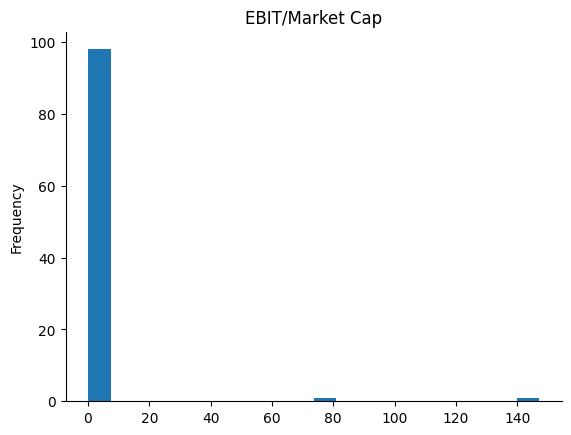

In [15]:
from matplotlib import pyplot as plt
_df_3['EBIT/Market Cap'].plot(kind='hist', bins=20, title='EBIT/Market Cap')
plt.gca().spines[['top', 'right',]].set_visible(False)

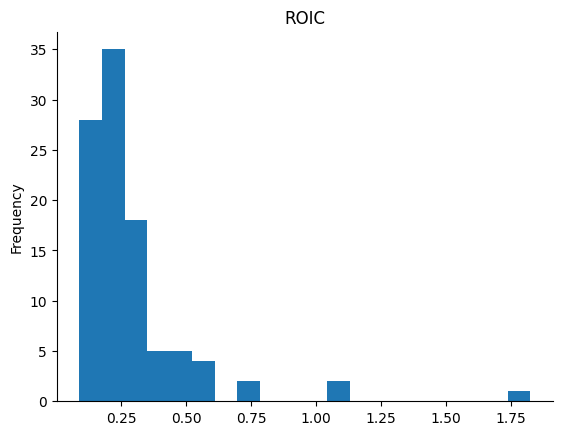

In [16]:
_df_3['ROIC'].plot(kind='hist', bins=20, title='ROIC')
plt.gca().spines[['top', 'right',]].set_visible(False)

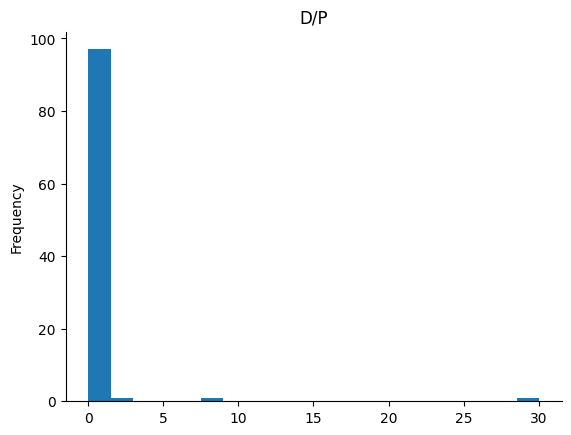

In [17]:
_df_3['D/P'].plot(kind='hist', bins=20, title='D/P')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
from google.colab import files

if not df_screened.empty:
    csv_filename = f"{region}_screened.csv"
    df.to_csv(csv_filename, index=False)
    files.download(csv_filename)
else:
    print(f"No data to download for {region}.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>